Replicate section IV of %[9] and comment on the hypothesis of the Fisher effect. Try to extend the findings to a more recent period after 2006. Consider if there is any conflict with the inflation model of Fama and Gibbons (1984) in **Chapter 6. Explain.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
us_cpi = pd.read_csv("us_cpi_inf.csv", parse_dates = ['TIME'])
us_ir = pd.read_csv("us_nom_ir.csv", parse_dates = ['TIME'])

In [3]:
us_cpi.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,USA,CPI,TOT,AGRWTH,M,1963-09-01,0.986842,NaN
1,USA,CPI,TOT,AGRWTH,M,1963-10-01,1.315789,NaN
2,USA,CPI,TOT,AGRWTH,M,1963-11-01,1.315789,NaN
3,USA,CPI,TOT,AGRWTH,M,1963-12-01,1.644737,NaN
4,USA,CPI,TOT,AGRWTH,M,1964-01-01,1.644737,NaN


In [4]:
us_ir.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,USA,STINT,TOT,PC_PA,M,1964-06-01,3.86,NaN
1,USA,STINT,TOT,PC_PA,M,1964-07-01,3.87,NaN
2,USA,STINT,TOT,PC_PA,M,1964-08-01,3.85,NaN
3,USA,STINT,TOT,PC_PA,M,1964-09-01,3.87,NaN
4,USA,STINT,TOT,PC_PA,M,1964-10-01,3.94,NaN


#### 1. Replication of paper: period 1974 to 2006

In [5]:
qry_v0 = "TIME > '1974-01-01' & TIME < '2006-10-31'"
us_cpi_v0 = us_cpi.query(qry_v0)
us_ir_v0 = us_ir.query(qry_v0)

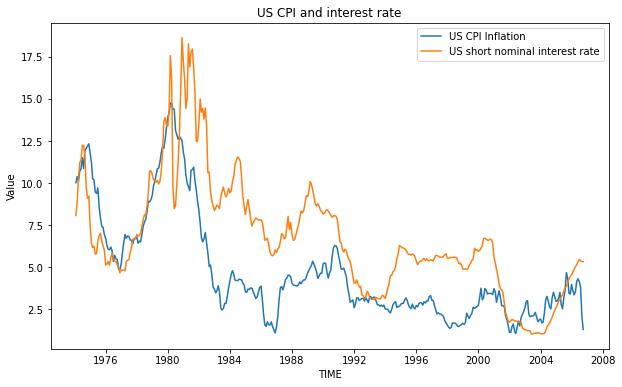

In [14]:
fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'TIME', y = 'Value', data = us_cpi_v0, ax = ax, label = 'US CPI Inflation')
sns.lineplot(x = 'TIME', y = 'Value', data = us_ir_v0, ax = ax, label = 'US short nominal interest rate')
ax.set_title('US CPI and interest rate');

In [15]:
def adf_test(df, col = 'Value'):
    X = df[col]
    result = adfuller(X)
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [16]:
adf_test(us_cpi_v0)

ADF Statistic: -2.149654
p-value: 0.225023
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [17]:
adf_test(us_ir_v0)

ADF Statistic: -2.413003
p-value: 0.138100
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Based on the p-value of the ADF test, null hypothesis of a unit root cannot be rejected for either variable. 

In [39]:
df_combine = pd.merge(us_cpi_v0[['TIME', 'Value']], us_ir_v0[['TIME', 'Value']], on = 'TIME', suffixes = ('_cpi', '_ir'))
df_combine.set_index('TIME', inplace = True)

In [19]:
df_combine.head()

,Value_cpi,Value_ir
TIME,,
1974-02-01,10.02331,8.08
1974-03-01,10.39261,8.84
1974-04-01,10.09174,10.25
1974-05-01,10.70615,11.20
1974-06-01,10.85973,11.38


In [20]:
from statsmodels.tsa.api import VAR

In [21]:
model = VAR(endog = df_combine)
res = model.select_order(15)
res.summary()

C:\Users\yan2j\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,3.916,3.936,50.18,3.924
1,-2.943,-2.881,0.05269,-2.919
2,-3.200,-3.096,0.04076,-3.159
3,-3.273,-3.127*,0.03788,-3.215
4,-3.257,-3.069,0.03851,-3.182
5,-3.272,-3.043,0.03794,-3.181
6,-3.266,-2.995,0.03816,-3.159
7,-3.326,-3.014,0.03594,-3.202
8,-3.331,-2.977,0.03578,-3.190
9,-3.358,-2.962,0.03482,-3.201


In [36]:
def johansen_coint_test(df, order, lag):
    jres = coint_johansen(df, order, lag)
    
    for i in range(len(df.columns)):
        print('J_trace for {} cointegrating vector(s): {}'.format(i,round(jres.trace_stat[i], 4)))
        print('Critical values:')
        print('\t 10%: {}'.format(round(jres.trace_stat_crit_vals[i][0], 4)))
        print('\t 5%: {}'.format(round(jres.trace_stat_crit_vals[i][1], 4)))
        print('\t 1%: {}'.format(round(jres.trace_stat_crit_vals[i][2], 4)))

    for j in range(len(df.columns)):
        print('J_max for {} cointegrating vector(s): {}'.format(j,round(jres.max_eig_stat[j], 4)))
        print('Critical values:')
        print('\t 10%: {}'.format(round(jres.max_eig_stat_crit_vals[j][0], 4)))
        print('\t 5%: {}'.format(round(jres.max_eig_stat_crit_vals[j][1], 4)))
        print('\t 1%: {}'.format(round(jres.max_eig_stat_crit_vals[j][2], 4)))

In [40]:
johansen_coint_test(df_combine, 0, 10)

J_trace for 0 cointegrating vector(s): 23.8584
Critical values:
	 10%: 13.4294
	 5%: 15.4943
	 1%: 19.9349
J_trace for 1 cointegrating vector(s): 5.557
Critical values:
	 10%: 2.7055
	 5%: 3.8415
	 1%: 6.6349
J_max for 0 cointegrating vector(s): 18.3013
Critical values:
	 10%: 12.2971
	 5%: 14.2639
	 1%: 18.52
J_max for 1 cointegrating vector(s): 5.557
Critical values:
	 10%: 2.7055
	 5%: 3.8415
	 1%: 6.6349


At the 5% significance level, we reject the null hypothesis of no zero cointegrating vectors, i.e. there exists a cointegrating relationship.

#### 2. Latest sub period: 2006 to 2020

In [42]:
qry_v1 = "TIME > '2006-10-31' & TIME < '2020-12-31'"
us_cpi_v1 = us_cpi.query(qry_v1)
us_ir_v1 = us_ir.query(qry_v1)

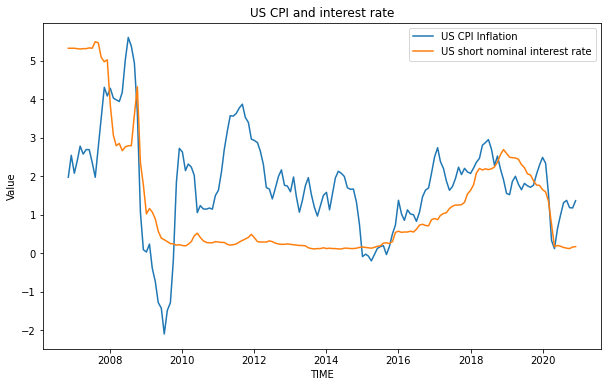

In [41]:
fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'TIME', y = 'Value', data = us_cpi_v1, ax = ax, label = 'US CPI Inflation')
sns.lineplot(x = 'TIME', y = 'Value', data = us_ir_v1, ax = ax, label = 'US short nominal interest rate')
ax.set_title('US CPI and interest rate');

In [26]:
adf_test(us_cpi_v1)

ADF Statistic: -2.723199
p-value: 0.070109
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


In [27]:
adf_test(us_ir_v1)

ADF Statistic: -4.376677
p-value: 0.000326
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


In [43]:
df_combine = pd.merge(us_cpi_v1[['TIME', 'Value']], us_ir_v1[['TIME', 'Value']], on = 'TIME', suffixes = ('_cpi', '_ir'))
df_combine.set_index('TIME', inplace = True)

In [44]:
johansen_coint_test(df_combine, 0, 10)

J_trace for 0 cointegrating vector(s): 37.6849
Critical values:
	 10%: 13.4294
	 5%: 15.4943
	 1%: 19.9349
J_trace for 1 cointegrating vector(s): 16.6129
Critical values:
	 10%: 2.7055
	 5%: 3.8415
	 1%: 6.6349
J_max for 0 cointegrating vector(s): 21.0721
Critical values:
	 10%: 12.2971
	 5%: 14.2639
	 1%: 18.52
J_max for 1 cointegrating vector(s): 16.6129
Critical values:
	 10%: 2.7055
	 5%: 3.8415
	 1%: 6.6349


#### 3. Full period: 1974 to 2020

In [45]:
qry_v2 = "TIME > '1974-01-01' & TIME < '2020-12-31'"
us_cpi_v2 = us_cpi.query(qry_v2)
us_ir_v2 = us_ir.query(qry_v2)

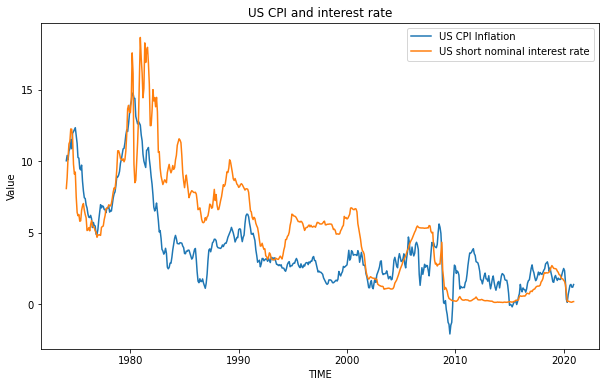

In [46]:
fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'TIME', y = 'Value', data = us_cpi_v2, ax = ax, label = 'US CPI Inflation')
sns.lineplot(x = 'TIME', y = 'Value', data = us_ir_v2, ax = ax, label = 'US short nominal interest rate')
ax.set_title('US CPI and interest rate');

In [32]:
adf_test(us_cpi_v2)

ADF Statistic: -2.628305
p-value: 0.087287
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [33]:
adf_test(us_ir_v2)

ADF Statistic: -1.986228
p-value: 0.292644
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [47]:
df_combine = pd.merge(us_cpi_v2[['TIME', 'Value']], us_ir_v2[['TIME', 'Value']], on = 'TIME', suffixes = ('_cpi', '_ir'))
df_combine.set_index('TIME', inplace = True)

In [48]:
johansen_coint_test(df_combine, 0, 10)

J_trace for 0 cointegrating vector(s): 28.0761
Critical values:
	 10%: 13.4294
	 5%: 15.4943
	 1%: 19.9349
J_trace for 1 cointegrating vector(s): 4.4424
Critical values:
	 10%: 2.7055
	 5%: 3.8415
	 1%: 6.6349
J_max for 0 cointegrating vector(s): 23.6337
Critical values:
	 10%: 12.2971
	 5%: 14.2639
	 1%: 18.52
J_max for 1 cointegrating vector(s): 4.4424
Critical values:
	 10%: 2.7055
	 5%: 3.8415
	 1%: 6.6349
